In [2]:
# for breast cancer
# import package
from sklearn.datasets import load_breast_cancer
# -----------manipulate data package-----------
import pandas as pd
import numpy as np
# -----------machine learning package-----------
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier,DMatrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix

# -----------ploting package-----------
import matplotlib
import matplotlib.pyplot as plt
# for plot showing log in xscale
matplotlib.rc('font', family='Arial')
%matplotlib inline 
# plot in jupyter

In [3]:
# load data csv or db
# load breast cancer dataset
cancer = load_breast_cancer()
data_ay = np.c_[cancer.data, cancer.target]

columns = np.append(cancer.feature_names, ["target"])
data = pd.DataFrame(data_ay, columns=columns)

no_cancer = data[data['target']==0].copy().reset_index(drop=True)
cancered = data[data['target']==1].copy().reset_index(drop=True)

print(len(no_cancer),len(cancered))
canceredc = cancered.copy()

212 357


In [4]:
SBS_list = ['mean concave points', 'mean fractal dimension', 'texture error', 'area error'\
 , 'compactness error', 'worst texture', 'worst symmetry']
# 用特徵篩選完的欄位
X = data[SBS_list].values
y = data.iloc[:,-1].values.astype('int32')
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1)

In [5]:
pipe_rf = Pipeline([('scl',StandardScaler()),('rf',RandomForestClassifier(random_state=1,))])

In [6]:
pipe_rf.fit(X_train,y_train)
print('Train Accuracy:%.3f' % pipe_rf.score(X_train,y_train))
print('Test Accuracy:%.3f' % pipe_rf.score(X_test,y_test))

Train Accuracy:1.000
Test Accuracy:0.956


In [7]:
# kfold 範例程式碼
kfold = StratifiedKFold(n_splits=10,random_state=1)

scores=[]
for k,(train, test) in enumerate(kfold.split(X_train, y_train)):
    pipe_rf.fit(X_train[train],y_train[train])
    score = pipe_rf.score(X_train[test],y_train[test])
    scores.append(score)
    print('Fold: %s, Class dist,: %s,Acc: %.3f' %(k+1,np.bincount(y_train[train]),score))
print('CV accuracy: %.3f +/- %.3f' %(np.mean(scores),np.std(scores)))

Fold: 1, Class dist,: [153 256],Acc: 0.913
Fold: 2, Class dist,: [153 256],Acc: 0.978
Fold: 3, Class dist,: [153 256],Acc: 0.957
Fold: 4, Class dist,: [153 256],Acc: 0.935
Fold: 5, Class dist,: [153 256],Acc: 0.935
Fold: 6, Class dist,: [153 257],Acc: 0.978
Fold: 7, Class dist,: [153 257],Acc: 0.933
Fold: 8, Class dist,: [153 257],Acc: 0.933
Fold: 9, Class dist,: [153 257],Acc: 0.933
Fold: 10, Class dist,: [153 257],Acc: 0.956
CV accuracy: 0.945 +/- 0.020


In [8]:
# 實際上用cross_val_score就行
scores = cross_val_score(estimator=pipe_rf,X=X_train,y=y_train,cv=10,n_jobs=1)
print('CV accuracy scores:%s' %scores)
print('CV accuracy:%.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

CV accuracy scores:[ 0.91304348  0.97826087  0.95652174  0.93478261  0.93478261  0.97777778
  0.93333333  0.93333333  0.93333333  0.95555556]
CV accuracy:0.945 +/- 0.020


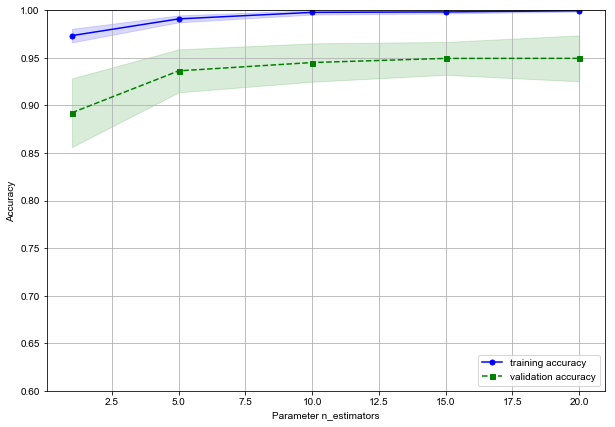

In [9]:
# # validate_curve
param = 'n_estimators'
param_range = [1,5,10,15,20]
train_scores,test_scores = validation_curve(estimator=pipe_rf,X=X_train,\
                                            y=y_train,param_name='rf__'+param,param_range=param_range,cv=10)


train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores,axis=1)
plt.figure(figsize=(10,7))
plt.plot(param_range,train_mean,color='blue',marker = 'o',markersize=5,label='training accuracy')

plt.fill_between(param_range,train_mean+train_std,train_mean - train_std,alpha=0.15,color='blue')



plt.plot(param_range,test_mean,color='green',linestyle='--',marker='s',markersize=5,label='validation accuracy')
plt.fill_between(param_range,test_mean + test_std,test_mean-test_std,alpha=0.15,color='green')

plt.grid()
# plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter '+param)
plt.ylabel('Accuracy')

plt.ylim([0.6,1.0])
plt.show()

In [10]:
# https://github.com/barrachri/imbalanced_datasets/blob/master/utils.py

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Plot the confusion matrix.
    The returned matrix is normalized but shows the original value
    """
    
    plt.figure(figsize=SIZE_IMAGE)
    
    cm_n = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm_n, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm_n.max() / 3.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        
        color="white" if cm_n[i, j] > thresh else "black"
        
        value_normalized = cm_n[i, j]
        value = cm[i, j] 
        
        # print original values
        plt.text(j, i, format(value),
                 horizontalalignment="center",
                 verticalalignment='top',
                 color=color)
        
        # print normalized values
        plt.text(j, i, format(value_normalized,'.2f'),
                 horizontalalignment="center",
                 verticalalignment='bottom',
                 color=color)  
          

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

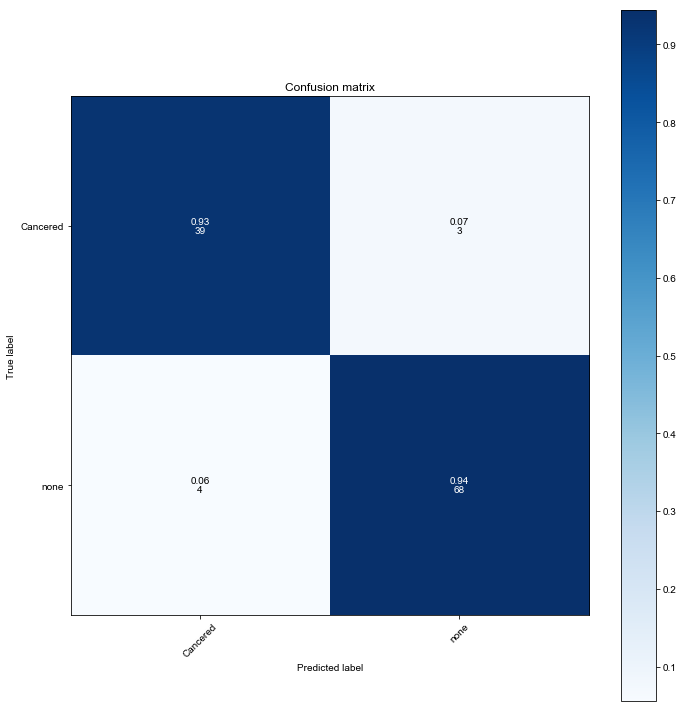

In [11]:
## confusion matrix for check classification good or bad

y_pred = pipe_rf.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)

classes = ("Cancered", "none")
SIZE_IMAGE = (10,10)
import itertools
plot_confusion_matrix(confmat, classes=classes, title='Confusion matrix')